In [ ]:
from google.colab import drive
drive.mount('/content/drive')
%cd "/content/drive/My Drive/repo_tesis/entorno_tesis_Molina"
!source bin/activate

Mounted at /content/drive
/content/drive/My Drive/repo_tesis/entorno_tesis_Molina


Importo las librerías

In [ ]:
# !pip install lmoments3

import numpy as np
import pickle
import joblib
import pandas as pd
import sys
import matplotlib.pyplot as plt

# sys.path.append("/content/drive/My Drive/repo_tesis/lib")
# import functions as f

Levanto los datos

In [ ]:
%cd "/content/drive/My Drive/repo_tesis/data"
# Load data
file = open('MyoArmband_data_exp1_cor.pickle', 'rb')
MyoArm_data = pickle.load(file)
file.close()

/content/drive/My Drive/repo_tesis/data


Defino los parámetros que voy a usar

In [ ]:
fs = MyoArm_data['S1']['info']['fs'] # Frecuency in Hz
nOfSubjects = 10 # N° of Subjects [1,...,10]- cantidad de sujetos con lo que voy a trabajar
nChannels = 16 # N° of Channels- numero de canales con los que quiero trabajar- el maximo es MyoArm_data['S1']['emg'].shape[1]+1
w_ms = 200 # Window length in ms. Largo de la ventana sobre la que calculo las features
s_ms = 50 # Window increment in ms. Incremento de ventana sobre la que calculo las features, o separación entre cada ventana consecutiva
W_s = int(fs*w_ms/1000) # Window length in samples
I_s = int(fs*s_ms/1000) # Window increment in samples

Extraigo los datos

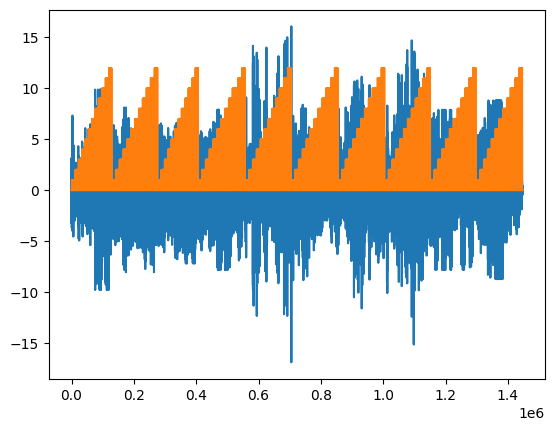

In [ ]:
data_list = []  # en cada elemento de la lista guardo los datos de un sujeto, luego los concateno
label_list = [] # lo mismo que para la anterior
suject_list = []   # aqui se indica a que sujeto pertenece la senal a lo largo del tiempo

for i in range(1, nOfSubjects+1):
    data_list.append(MyoArm_data['S'+str(i)]['emg'])
    label_list.append(MyoArm_data['S'+str(i)]['label'])
    suject_list.append(MyoArm_data['S'+str(i)]['label']*0 + i)

# Ahora tengo que concatenar los elementos de la lista
data = []
label = []
suject = []
for i in range(len(data_list)):
    data.extend(data_list[i])
    label.extend(label_list[i])
    suject.extend(suject_list[i])

data = np.array(data)
label = np.array(label)
suject = np.array(suject)

# Visualizacion de la senal 1 de todos los sujetos
plt.figure()
plt.plot(data[:, 0])
plt.plot(label)
plt.show()

# Quiero identificar cada ventana de gesto con un numero
indices_ventanas = np.where(np.diff(label)!=0)[0]
id_ventanas_gestos = np.zeros(int(len(indices_ventanas)/2))
# Me voy a quedar solo con los elementos pares que son los que marcan el inicio de una ventana
# de esta forma la posicion en el vector los va a identificar, y el valor en la celda me permite ubicarlo, ya que es su principio
for i in range(int(len(indices_ventanas)/2)):
    id_ventanas_gestos[i] = indices_ventanas[2*i]


Ahora que tengo todos los datos juntos podria calcular las features.
Sin embargo no voy a calcular features en todas las ventanas posibles, me voy a quedar solo con las que se solapen determinado porcentaje con un lugar en el que label no sea 0, es decir que haya gesto. También voy a desechar las ventanas que abarquen dos gestos distintos.


In [ ]:
ventanas_admitidas = []     # en cada elemento guardo los indices de las ventanas permitidas

# Esta es la cantidad de ventanas que supuestamente tengo que probar. Esto lo saque del codigo de renato
l = int((len(data)-W_s+I_s)/I_s) # N° of windows in the register

# Parametros:
costo_gesto0 = 1    # Costo expresado en ventanas admitidas con solapamiento, para ingresar una ventana de reposo. 12 si quiero misma proporcion. 1 se quiero gesto/reposo
fraccion_solapamiento_ventana = 0.5
condicion_solapamiento = fraccion_solapamiento_ventana*W_s  # cantidad de muestras minima de solapamiento para admitir la ventana

barrita_costo_gesto0 = 0    # Se le suma uno cuando agrego una ventana admitida con solapamiento, y se le resta el valor de cupo luego de agregar una de reposo
delay_muestras_reposo = I_s

for i in range(l):   # 10009, 10010
    # me voy a crear una ventana auxiliar para compararla con las etiquetas y ver si hay superposicion
    vent_aux = np.zeros(len(label))
    vent_aux[i*I_s: i*I_s+W_s] = 1

    comp = vent_aux*label   # comparo la ventana con el vector label
    if np.max(comp) != 0:   # si el maximo es 0 es porque no se superponen
        comp = comp/np.max(comp)    # para que la suma de la cantidad de muestras que se superponen
        muestras_super = np.sum(comp)
    else:
        if barrita_costo_gesto0 >= costo_gesto0:
            ventanas_admitidas.append([i*I_s+delay_muestras_reposo, i*I_s+W_s+delay_muestras_reposo, -1, 0, -1])    # TODO no me interesa identificar ni entre que repeticiones está, ni el sujeto, no?
            barrita_costo_gesto0 += -costo_gesto0
    if (np.max(comp) != 0) and (muestras_super >= condicion_solapamiento):
        indices_no_cero = np.where(np.diff(comp) != 0)  # esto es para chequear que la ventana no abarque dos ventanas de gestos distintas
        if len(indices_no_cero[0]) < 3:
            # Para identificar la ventana de gesto voy a buscar el comienzo de ventana mas cercano menor al primer elemento de comp distinto de 0
            ind_comp_no_cero = np.where(comp != 0)[0]
            id_ventana = np.argmin(np.abs(ind_comp_no_cero[0] - id_ventanas_gestos))
            if id_ventanas_gestos[id_ventana] > ind_comp_no_cero[0]:    # el comienzo tiene que ser menor a la parte en la que coindicen, porque una ventana no puede abarcar dos ventanas de gestos distintas
                id_ventana += -1    # esto es dificil que pase pero estaria bueno chequear que funcione

            # Para averiguar el gesto y sujeto evaluamos label y suject en alguna muestra donde comp no sea cero
            label_act = label[ind_comp_no_cero[0]]
            suject_act = suject[ind_comp_no_cero[0]]

            # Principio, fin de ventana, identificador, gesto de la ventana, sujeto
            ventanas_admitidas.append([i*I_s, i*I_s+W_s, id_ventana, label_act, suject_act])
            barrita_costo_gesto0 += 1
for i in range(len(ventanas_admitidas)):
  if ventanas_admitidas[i][4] == -1:
    ventanas_admitidas[i][4] = ventanas_admitidas[i-1][4]

ventanas_admitidas = np.array(ventanas_admitidas)
ind_reposo = np.where(ventanas_admitidas[:, 2]==-1)[0]  # me fijo los indices que son reposo
ind_ventanas_reposo = np.where(np.diff(ind_reposo)!=1)[0]   # calculos los bordes de cada "repeticion de reposo"

# Insertar el valor al principio del array
ind_ventanas_reposo = np.insert(ind_ventanas_reposo, 0, 0)

# Me fijo la cantidad de repeticiones, para empezar a numerar a las repeticiones de reposo desde ahi
max_repeticiones = np.max(ventanas_admitidas[:, 2])

for i in range(len(ind_ventanas_reposo)):
    if i==0:
        ini = ind_reposo[ind_ventanas_reposo[i]]
        fin = ind_reposo[ind_ventanas_reposo[i+1]]+1
    elif i==len(ind_ventanas_reposo)-1:
        ini = ind_reposo[ind_ventanas_reposo[i]+1]
        fin = ind_reposo[-1]+1
    else:
        ini = ind_reposo[ind_ventanas_reposo[i]+1]
        fin = ind_reposo[ind_ventanas_reposo[i+1]]+1
    ventanas_admitidas[ini:fin, 2] = max_repeticiones + i + 1



In [ ]:
%cd "/content/drive/My Drive/repo_tesis/src/gesto_reposo/datos"
joblib.dump(ventanas_admitidas, "ventanas_admitidas_50_50.pkl")
joblib.dump(data, "data_ventanas_admitidas_50_50.pkl")


/content/drive/My Drive/repo_tesis/src/gesto_reposo/datos


NameError: name 'ventanas_admitidas' is not defined

In [ ]:
%cd "/content/drive/My Drive/repo_tesis/src/gesto_reposo/datos"
joblib.dump(label, "label_ventanas_admitidas_50_50.pkl")


/content/drive/My Drive/repo_tesis/src/gesto_reposo/datos


['label_ventanas_admitidas_50_50.pkl']

In [ ]:
%cd "/content/drive/My Drive/repo_tesis/src/gesto_reposo/datos"
ventanas_admitidas = joblib.load("ventanas_admitidas_50_50.pkl")
data = joblib.load("data_ventanas_admitidas_50_50.pkl")
label = joblib.load("label_ventanas_admitidas_50_50.pkl")

/content/drive/My Drive/repo_tesis/src/gesto_reposo/datos


In [ ]:
print(ventanas_admitidas)

[[    950     990       0       1       1]
 [    960    1000       0       1       1]
 [    970    1010       0       1       1]
 ...
 [1446590 1446630    1419       0      10]
 [1446600 1446640    1419       0      10]
 [1446610 1446650    1419       0      10]]


In [ ]:
# En las primeras dos columnas tengo los principios y fin de cada ventana
ventanas_reposo_ind = np.where(ventanas_admitidas[:, 3]==0)[0]
ventanas_reposo = ventanas_admitidas[ventanas_reposo_ind, :]
ventanas_reposo

array([[   1730,    1770,     710,       0,       1],
       [   1740,    1780,     710,       0,       1],
       [   1750,    1790,     710,       0,       1],
       ...,
       [1446590, 1446630,    1419,       0,      10],
       [1446600, 1446640,    1419,       0,      10],
       [1446610, 1446650,    1419,       0,      10]])

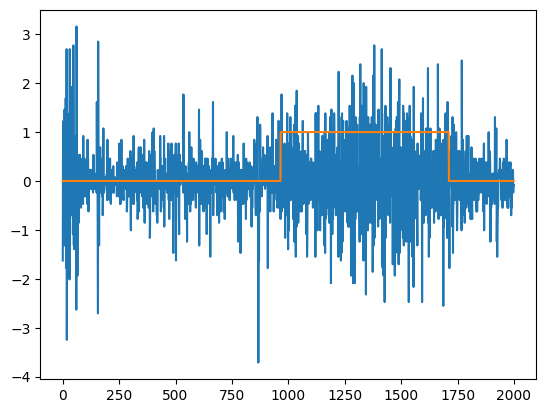

In [ ]:
plt.figure()
plt.plot(data[0:2000, 0], )
plt.plot(label[0:2000])

In [ ]:
ventanas_gesto_ind = np.where(ventanas_admitidas[:, 3]!=0)[0]
ventanas_gesto = ventanas_admitidas[ventanas_gesto_ind, :]
ventanas_gesto

array([[    950,     990,       0,       1,       1],
       [    960,    1000,       0,       1,       1],
       [    970,    1010,       0,       1,       1],
       ...,
       [1445670, 1445710,     709,      12,      10],
       [1445680, 1445720,     709,      12,      10],
       [1445690, 1445730,     709,      12,      10]])

In [ ]:
# para chequear la proporcion de ventanas de reposo y gesto
print(len(ventanas_reposo), len(ventanas_gesto))

59563 59563


In [ ]:
# en primer lugar voy a calcular gesto representativo por sujeto. luego puedo evaluar combinar los de diferentes sujetos
cant_gestos = 13  # contando el reposo
cant_sujetos = 10
sep_gesto_sujeto = []
data_gesto_sujeto = []

for i in range(1, cant_sujetos+1): # 11
  sep_gestos = []
  data_sep_gestos = []
  ind_sujeto = np.where(ventanas_admitidas[:, 4]==i)[0]
  ventanas_sujeto = ventanas_admitidas[ind_sujeto]
  for j in range(cant_gestos):
    ind_gesto = np.where(ventanas_sujeto[:, 3]==j)[0]
    ventanas_sujeto_gesto = ventanas_sujeto[ind_gesto]
    sep_gestos.append(ventanas_sujeto_gesto)
    # print(ventanas_sujeto_gesto)
    data_sep_gestos_aux = []  # fijo sujeto y tipo de gesto. vario entre los que caen en esas categorias
    for k in range(len(ind_gesto)):
      # inicio y fin del pedazo de señal que voy a guardar
      ini = ventanas_sujeto_gesto[k][0]
      fin = ventanas_sujeto_gesto[k][1]
      data_sep_gestos_aux.append(data[ini:fin, :])

    data_sep_gestos.append(data_sep_gestos_aux)
  sep_gesto_sujeto.append(sep_gestos)
  data_gesto_sujeto.append(data_sep_gestos)


In [ ]:
# cada lista corresponde a un sujeto distinto, y dentro de cada una de estas listas, cada lista corresponde a un gesto distinto
sep_gesto_sujeto

In [ ]:
'''
primer subindice: sujeto
segundo subindice: gesto
tercer subindice: fragmento de señal correspondiente ndarray(largo_ventana, 16) porque tiene 16 canales
'''
a = data_gesto_sujeto[0][1]



In [ ]:
# 1) Para cada sujeto y gesto, obtener una señal promedio
sigs_prom = []  # primer indice-->sujeto. segundo indice--> gesto, tercer indice--> canal
for i in range(cant_sujetos):
  sigs_prom_sujeto = []
  for j in range(cant_gestos):
    array_3d = np.array(data_gesto_sujeto[i][j])
    sigs_prom_sujeto.append(np.mean(array_3d, axis=0))
  sigs_prom.append(sigs_prom_sujeto)


In [ ]:
# primer subindice sujeto, segundo gesto, (40,16)--> puedo elegir canal
b = sigs_prom[0][0]

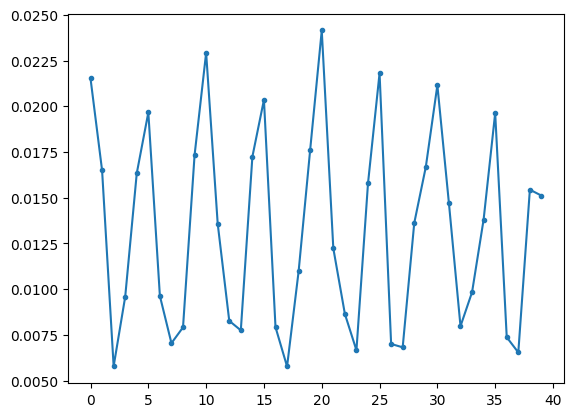

In [ ]:
plt.figure()
plt.plot(sigs_prom[0][0][:, 1], '.-')

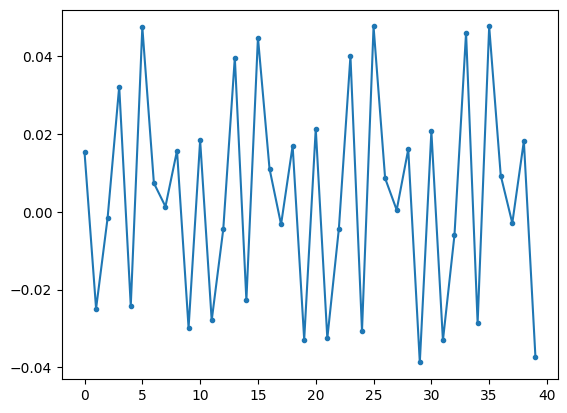

In [ ]:
plt.figure()
plt.plot(sigs_prom[0][1][:, 0], '.-')